In [1]:
# system ----
import os
import sys
import pandas as pd
import numpy as np
import csv

%matplotlib inline
import matplotlib.pyplot as plt

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# local ----
sys.path.append("modules")
import plot_parameters 

print(sys.version)

3.9.6 (default, Aug 18 2021, 12:38:10) 
[Clang 10.0.0 ]


---
# Data Sample 

[Link](https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data)

From the link above, the data description is an hourly data set containing the PM2.5 data of US Embassy in Beijing for over 5 years. The data attributes are as follows:

* ___No___: row number
* ___year___: year of data in this row
* ___month___: month of data in this row
* ___day___: day of data in this row
* ___hour___: hour of data in this row
* ___pm2.5___: PM2.5 concentration (ug/m^3)
* ___DEWP___: Dew Point (â„ƒ)
* ___TEMP___: Temperature (â„ƒ)
* ___PRES___: Pressure (hPa)
* ___cbwd___: Combined wind direction
* ___iws___: Cumulated wind speed (m/s)
* ___is___: Cumulated hours of snow
* ___ir___: Cumulated hours of rain 

We want to look at the `pm2.5` elements. For context, the _fine particulate matter_ (`pm2.5`) is an air pollutant that is a concern for people's health when levels in air are high. They are tiny particles in the air that reduce visibility and cause the air to appear hazy when levels are elevated. Looking at the contents,

In [2]:
# >>> Import file

df_ = pd.read_csv("dataset/PRSA_data_2010.1.1-2014.12.31.csv").dropna(axis=0)
print(df_.shape)
df_

(41757, 13)


,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
24,25,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0
25,26,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0
26,27,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0
27,28,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0
28,29,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [3]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41757 entries, 24 to 43823
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      41757 non-null  int64  
 1   year    41757 non-null  int64  
 2   month   41757 non-null  int64  
 3   day     41757 non-null  int64  
 4   hour    41757 non-null  int64  
 5   pm2.5   41757 non-null  float64
 6   DEWP    41757 non-null  int64  
 7   TEMP    41757 non-null  float64
 8   PRES    41757 non-null  float64
 9   cbwd    41757 non-null  object 
 10  Iws     41757 non-null  float64
 11  Is      41757 non-null  int64  
 12  Ir      41757 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.5+ MB


The day, month and year are in seperate columns. We need to combine the day, month, and year columns into one singular object to analyze. Lets save a post-processed version for analysis done later on in this notebook.

In [4]:
print("Total years range from", df_['year'].min(), "-",  df_['year'].max())
print("Total concentration range from", df_['pm2.5'].min(), "-",  df_['pm2.5'].max())

# Combine values into one "date" column
cols = ["year", "month", "day"]
df_['date'] = df_[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
df_['date'] = pd.to_datetime(df_['date']).dt.strftime("%Y-%m-%d")

df_.to_csv("dataset/post-PRSA_data.csv", index=False)

df_.head()

Total years range from 2010 - 2014
Total concentration range from 0.0 - 994.0


,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,date
24,25,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0,2010-01-02
25,26,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0,2010-01-02
26,27,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0,2010-01-02
27,28,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0,2010-01-02
28,29,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0,2010-01-02


Lets see how the data looks as a function of time. Note that when plotting datetime like I do below, the x-axis is plotting based off of the _dataframes' index_

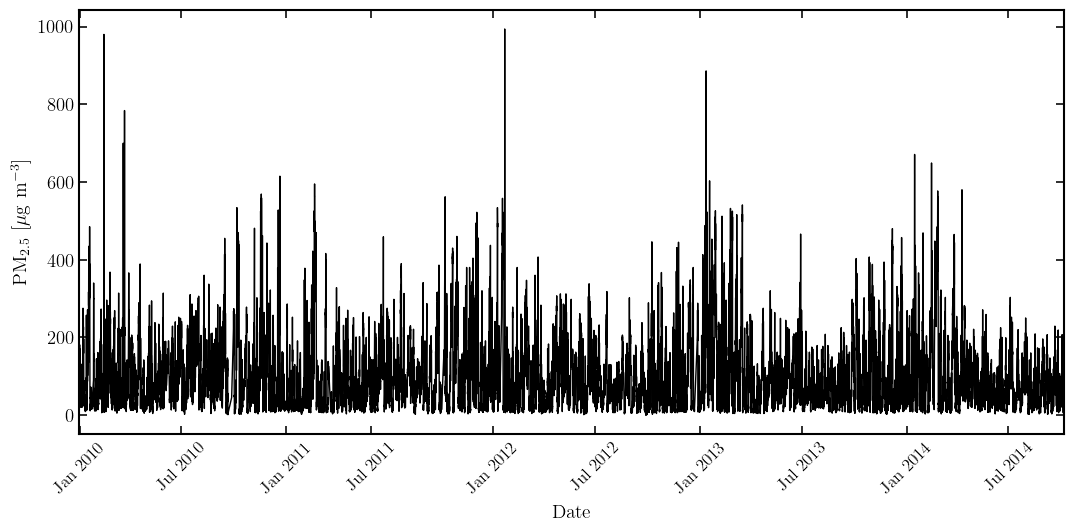

In [5]:
# Initialize figure
fig, ax = plt.subplots(figsize=(15.25/1.2, 6.75/1.2), nrows=1, ncols=1, dpi=100)
ax.xaxis.set_tick_params(direction='in', which='both'); ax.yaxis.set_tick_params(direction='in', which='both')
ax.xaxis.set_ticks_position('both'); ax.yaxis.set_ticks_position('both')
ax.set_xscale('linear'); ax.set_yscale('linear');
ax.set_xlabel(r'$\rm Date$'); ax.set_ylabel(r'$\rm PM_{2.5}\ [\mu g\ m^{-3}]$')

# Plot results
df_[['pm2.5', 'date']].plot(ax=ax, color='k', lw=1., legend=False, label="")

# Generate modified x-labels based on index location
ax.set_xlim(0.0, df_.shape[0]);
ax.xaxis.set_ticks(np.linspace(0.0, df_.shape[0], 5))
date_list = ["2010-01-02", "2010-07-01", "2011-01-02", "2011-06-01", 
             "2012-01-02", "2012-07-01", "2013-01-02", "2013-07-01", 
             "2014-01-02", "2014-07-01"]
ind_list = []
for date in date_list:
    mask = (df_['date'] == date)
    ind_list.append(df_.loc[mask].index[0])
labels = [r"$\rm Jan\ 2010$", r"$\rm Jul\ 2010$", r"$\rm Jan\ 2011$", r"$\rm Jul\ 2011$", 
          r"$\rm Jan\ 2012$", r"$\rm Jul\ 2012$", r"$\rm Jan\ 2013$", r"$\rm Jul\ 2013$", 
          r"$\rm Jan\ 2014$", r"$\rm Jul\ 2014$"]
ax.set_xticks(ind_list)
ax.set_xticklabels(labels, rotation=45, fontsize=12.5)

# Plot line legend
#ax.legend(frameon=False, loc='upper left', fontsize=12.5, handlelength=3, handletextpad=0.3, labelspacing=0.05)

plt.show()

Interestingly, the air pollution spikes every start of a new year! We should tell them or something.

### Other dependable variables

We should also look at the other response variables (which we will use a features) as a function of time. Since the quantities of the Dew point, pressure, and temperature vary my by orders or magnitude, we should scale it since we just only want to look at the trend over time:

In [6]:
from sklearn.preprocessing import MinMaxScaler

# Scale output values between 0 and 1
df_[['sDEWP', 'sTEMP', 'sPRES', 'sIws']] = MinMaxScaler().fit_transform(df_[['DEWP', 'TEMP', 'PRES', 'Iws']])

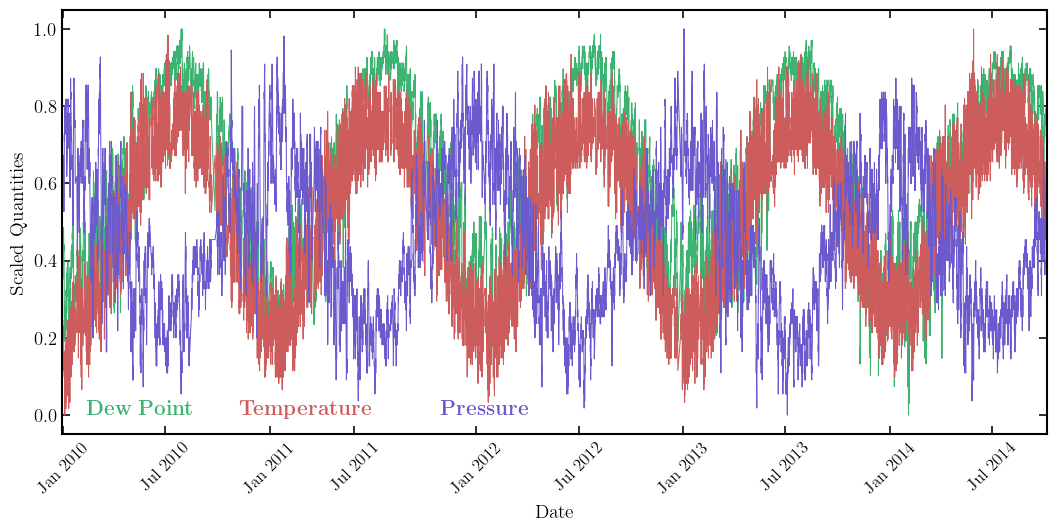

In [7]:
# Initialize figure
fig, ax = plt.subplots(figsize=(15.25/1.2, 6.75/1.2), nrows=1, ncols=1, dpi=100)
ax.xaxis.set_tick_params(direction='in', which='both'); ax.yaxis.set_tick_params(direction='in', which='both')
ax.xaxis.set_ticks_position('both'); ax.yaxis.set_ticks_position('both')
ax.set_xscale('linear'); ax.set_yscale('linear');
ax.set_xlabel(r'$\rm Date$'); ax.set_ylabel(r'$\rm Scaled\ Quantities$')

# Plot results
df_[['sDEWP', 'date']].plot(ax=ax, color='mediumseagreen', lw=0.75, legend=False, label="")
df_[['sTEMP', 'date']].plot(ax=ax, color='indianred', lw=0.75, legend=False, label="")
df_[['sPRES', 'date']].plot(ax=ax, color='slateblue', lw=0.75, legend=False, label="")
#df_[['sIws', 'date']].plot(ax=ax, color='darkgray', lw=0.75, legend=False, label="")

ax.text(1000, 0, r'\boldmath$\rm Dew\ Point$', color='mediumseagreen')
ax.text(7500, 0, r'\boldmath$\rm Temperature$', color='indianred')
ax.text(16000, 0, r'\boldmath$\rm Pressure$', color='slateblue')

# Generate modified x-labels based on index location
ax.set_xlim(0.0, df_.shape[0]);
ax.xaxis.set_ticks(np.linspace(0.0, df_.shape[0], 5))
date_list = ["2010-01-02", "2010-07-01", "2011-01-02", "2011-06-01", 
             "2012-01-02", "2012-07-01", "2013-01-02", "2013-07-01", 
             "2014-01-02", "2014-07-01"]
ind_list = []
for date in date_list:
    mask = (df_['date'] == date)
    ind_list.append(df_.loc[mask].index[0])
labels = [r"$\rm Jan\ 2010$", r"$\rm Jul\ 2010$", r"$\rm Jan\ 2011$", r"$\rm Jul\ 2011$", 
          r"$\rm Jan\ 2012$", r"$\rm Jul\ 2012$", r"$\rm Jan\ 2013$", r"$\rm Jul\ 2013$", 
          r"$\rm Jan\ 2014$", r"$\rm Jul\ 2014$"]
ax.set_xticks(ind_list)
ax.set_xticklabels(labels, rotation=45, fontsize=12.5)

plt.show()

### How about the PM2.5 readings from 1 May to 31 December 2014?

Lets quickly recreate figure (C) in Figure 1 of the [original paper](https://royalsocietypublishing.org/doi/epdf/10.1098/rspa.2015.0257).

In [8]:
START_DATE = "2014-05-01"; END_DATE = "2014-12-31"

mask = (df_['date'] > START_DATE) & (df_['date'] <= END_DATE)
df_.loc[mask][['pm2.5', 'date']]

,pm2.5,date
37968,47.0,2014-05-02
37969,44.0,2014-05-02
37970,34.0,2014-05-02
37971,28.0,2014-05-02
37972,34.0,2014-05-02
...,...,...
43819,8.0,2014-12-31
43820,10.0,2014-12-31
43821,10.0,2014-12-31
43822,8.0,2014-12-31


Note that after the masking, the plot will plot based on the index value, so it is crucial to reset the index values when plotting here

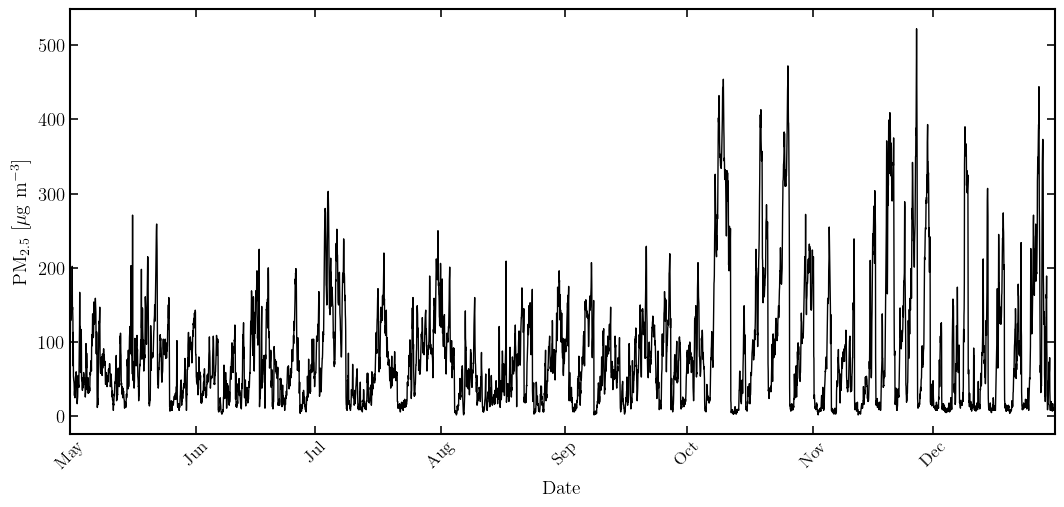

In [9]:
# Initialize figure
fig, ax = plt.subplots(figsize=(15.25/1.2, 6.75/1.2), nrows=1, ncols=1, dpi=100)
ax.xaxis.set_tick_params(direction='in', which='both'); ax.yaxis.set_tick_params(direction='in', which='both')
ax.xaxis.set_ticks_position('both'); ax.yaxis.set_ticks_position('both')
ax.set_xscale('linear'); ax.set_yscale('linear');
ax.set_xlabel(r'$\rm Date$'); ax.set_ylabel(r'$\rm PM_{2.5}\ [\mu g\ m^{-3}]$')

# Mask the dates and reset database index
START_DATE = "2014-05-01"; END_DATE = "2014-12-31"
mask = (df_['date'] >= START_DATE) & (df_['date'] <= END_DATE)
df_mask = df_.loc[mask].reset_index(drop=False)

# Plot masked results
df_mask[['pm2.5', 'date']].plot(ax=ax, color='k', lw=1., legend=False, label="")

# Generate modified x-labels based on index location
ax.set_xlim(0.0, df_mask.shape[0]);
ax.xaxis.set_ticks(np.linspace(0.0, df_mask.shape[0], 8))
date_list = ["2014-05-01", "2014-06-01", "2014-07-01", "2014-08-01", 
             "2014-09-01", "2014-10-01", "2014-11-01", "2014-12-01"]
ind_list = []
for date in date_list:
    mask = (df_mask['date'] == date)
    ind_list.append(df_mask.loc[mask].index[0])
labels = [r"$\rm May$", r"$\rm Jun$", r"$\rm Jul$", r"$\rm Aug$", 
          r"$\rm Sep$", r"$\rm Oct$", r"$\rm Nov$", r"$\rm Dec$"]
ax.set_xticks(ind_list)
ax.set_xticklabels(labels, rotation=45, fontsize=12.5)

# Plot line legend
#ax.legend(frameon=False, loc='upper left', fontsize=12.5, handlelength=3, handletextpad=0.3, labelspacing=0.05)

plt.show()

---

# Multivariate Time Series Forecasting

For this analysis, we will employ a special type of Neural Netwowrk called ___Long Short Term Memory___ (LSTM), which will be applicable for evaluating ___sequential, time series data___.

---

# Implementing LSTMs

A quick recap of the key concepts of LSTM.

1. LSTM can maintain a separate cell state from what they are outputting

2. They use gates to control the flow of information

3. Forget Gate is used to get rid of useless information

4. Store relevant information from the current input

5. Selectively update the cell state

* Output Gate returns the filtered version of the cell state Backpropagation over time with uninterrupted gradient flow 

* Backpropagation in LSTMs work similarly to how it was described in the RNN section.

---
### Preparing the data


Lets load in the post-processed air pollution made earlier in the notebook, so that we have the datetime values as our index:

In [10]:
# >>> Load the data

df = pd.read_csv('dataset/post-PRSA_data.csv', index_col='date', parse_dates=True)
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
date,,,,,,,,,,,,,
2010-01-02,25,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02,26,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02,27,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02,28,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02,29,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0


We now load in the data for this multivariate analysis. The output values should be `pm2.5`, but we also want to load in `DEWP`, `TEMP`, `PRES`, `lws`, `ls`, and `lr` as our features, as they should have dependence for the behaviour of pm2.5`:

In [11]:
# >>> Prepare the data

X = df.iloc[:, 6:-1].drop('cbwd', axis=1) # index date and other numerical values
y = df.iloc[:, 5:6]                       # the pm2.5 columns
#print(X, y)

It would be very beneficial to scale our outputs, as this is a regression problem. Otherwise, we will be dealing with huge loss values. We will use `scikit-learn`'s preprocessing functions: [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) for the features and [`MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for the response.

In [12]:
# >>> Pre-process the data

from sklearn.preprocessing import StandardScaler, MinMaxScaler

X_ss = StandardScaler().fit_transform(X) # standardize features by removing the mean and scaling to unit variance.
y_mm = MinMaxScaler().fit_transform(y)   # scale output values between 0 and 1

We will now split the dataset into trainig and testing sets. Since we are dealing with sequential data, and order is important, lets take the first a slighty higher percentage than half of rows for training, and the rest for testing the data:

In [13]:
# >>> Partition dataset into training and test data

# Training data
TRAIN_LIMIT = 30000
X_train = X_ss[:TRAIN_LIMIT, :]
y_train = y_mm[:TRAIN_LIMIT, :]

# Test data
X_test = X_ss[TRAIN_LIMIT:, :]
y_test = y_mm[TRAIN_LIMIT:, :]

print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape) 

Training Shape: (30000, 5) (30000, 1)
Testing Shape: (11757, 5) (11757, 1)


We now convert the numpy datasets to tensors using `PyTorch`

In [14]:
import torch
import torch.nn as nn
from torch.autograd import Variable 

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

print(X_train_tensors.shape, y_train_tensors.shape)
print(X_test_tensors.shape, y_test_tensors.shape)

torch.Size([30000, 5]) torch.Size([30000, 1])
torch.Size([11757, 5]) torch.Size([11757, 1])


Since LSTM is specially built for sequential data, it can not take in simple 2-D data as input. They need to have the timestamp information with them too, _since we need to have input at each timestamp_.

In [15]:
# >>> Reshaping to rows, timestamps, features

X_train_tensors_final = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([30000, 1, 5]) torch.Size([30000, 1])
Testing Shape torch.Size([11757, 1, 5]) torch.Size([11757, 1])


---
### Preparing LSTM model

Everything is set up now. For our LSTM model, we will 
1) Use 2 LSTM layers with the same hyperparameters stacked over each other (via `hidden_size`)
2) Define the 2 Fully Connected layers, the ReLU layer, and some helper variables. 
3) Define the forward pass of the LSTM: we will define the hidden state, and internal state first, initialized with zeros. 
4) Pass the hidden state and internal state in LSTM, along with the input at the current timestamp `t`, returning a new hidden state, current state, and output. 
5) Reshape the output so that it can pass to a Dense Layer. 
6) Apply activations, and pass them to the dense layers
7) Return the output.

In [16]:
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes # number of classes
        self.num_layers  = num_layers  # number of layers
        self.input_size  = input_size  # input size
        self.hidden_size = hidden_size # hidden state
        self.seq_length  = seq_length  # sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True) # LSTM function
        self.fc_1 = nn.Linear(hidden_size, 128)                                                                      # Layer 1 - Fully connected
        self.fc   = nn.Linear(128, num_classes)                                                                      # Layer 2 - Fully connected
        self.relu = nn.ReLU()                                                                                        # Layer 3 - activation function
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # internal state
        
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # LSTM with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size)          # reshaping the data for Dense layer next
        
        out = self.relu(hn)  # Activation dense layer
        out = self.fc_1(out) # First Dense
        out = self.relu(out) # Activation output
        out = self.fc(out)   # Final Output
        
        return out

The hyperparameters we will use are

In [17]:
# >>> Hyperparameters

NEPOCHS = 1000  # number of epochs
LR      = 0.001 # learning rate

INPUT_SIZE  = 5 # number of features
HIDDEN_SIZE = 2 # number of features in hidden state
NLAYERS     = 1 # number of stacked LSTM layers
NCLASSES    = 1 # number of output classes 

With everything prepared, we will not initilize our neural network and load in the criterion for loss and the optimizer. For the loss function and optimizer, we will use the standard (but sufficient) MSE (mean squre error) and Adam optimizer, respectively

In [18]:
lstm = LSTM(NCLASSES, INPUT_SIZE, HIDDEN_SIZE, NLAYERS, X_train_tensors_final.shape[1]) # define foward method
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=LR)

In [19]:
x_epoch = [] # all epochs
y_loss = []  # loss history
y_acc = []

for epoch in range(NEPOCHS):
    
    # train data
    outputs = lstm.forward(X_train_tensors_final) # forward pass
    optimizer.zero_grad()                         # calculate the gradient, then reseting it

    # calculate loss
    loss = criterion(outputs, y_train_tensors) # call loss function
    loss.backward()                            # calculate loss function
    optimizer.step()                           # update hypeparameters
    running_loss = loss.item()

    x_epoch.append(epoch)
    y_loss.append(running_loss)

    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, running_loss)) 

Epoch: 0, loss: 0.03286
Epoch: 100, loss: 0.00673
Epoch: 200, loss: 0.00621
Epoch: 300, loss: 0.00607
Epoch: 400, loss: 0.00600
Epoch: 500, loss: 0.00594
Epoch: 600, loss: 0.00589
Epoch: 700, loss: 0.00586
Epoch: 800, loss: 0.00583
Epoch: 900, loss: 0.00581


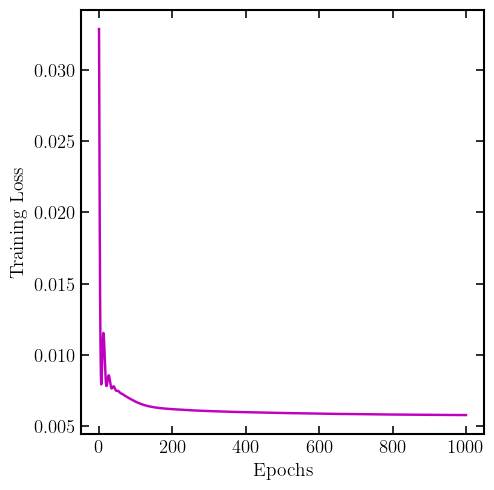

In [20]:
# Initialize figure
fig, ax = plt.subplots(figsize=(6.25/1.2, 6.75/1.2), nrows=1, ncols=1, dpi=100)
ax.xaxis.set_tick_params(direction='in', which='both'); ax.yaxis.set_tick_params(direction='in', which='both')
ax.xaxis.set_ticks_position('both'); ax.yaxis.set_ticks_position('both')
ax.set_xscale('linear'); ax.set_yscale('linear');
ax.set_xlabel(r'$\rm Epochs$'); ax.set_ylabel(r'$\rm Training\ Loss$')

ax.plot(x_epoch, y_loss, c='m', lw=1.75)

plt.show()

The running loss for our takes a very interesting shape over the epochs, but quickly decays and converges to an asymptote of around 0.006

---
### LSTM model predictions

With the LSTM model ran, lets reapply the transformation with the preprocessing variables, apply the tensors to the LSTM foward method, and inverse transform to remove the scalings applied to the dataset.

In [21]:
# Define preprocessing functions (so we can apply the inverse transformation)
ss = StandardScaler()
mm = MinMaxScaler()

# Old transformers
df_X_ss = ss.fit_transform(df.iloc[:, 6:-1].drop('cbwd', axis=1)) 
df_y_mm = mm.fit_transform(df.iloc[:, 5:6])

# Converting to Tensors
df_X_ss = Variable(torch.Tensor(df_X_ss)) 
df_y_mm = Variable(torch.Tensor(df_y_mm))

# Reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))

# Pass through forward method and convert to numpy array
train_predict = lstm(df_X_ss)
data_predict = train_predict.data.numpy() 
dataY_plot = df_y_mm.data.numpy()

# Inverse transformation scalings to return original values
data_predict = mm.inverse_transform(data_predict) 
dataY_plot = mm.inverse_transform(dataY_plot)

Lets see now how the predictor compares to the real thing when using a subsample dataset:

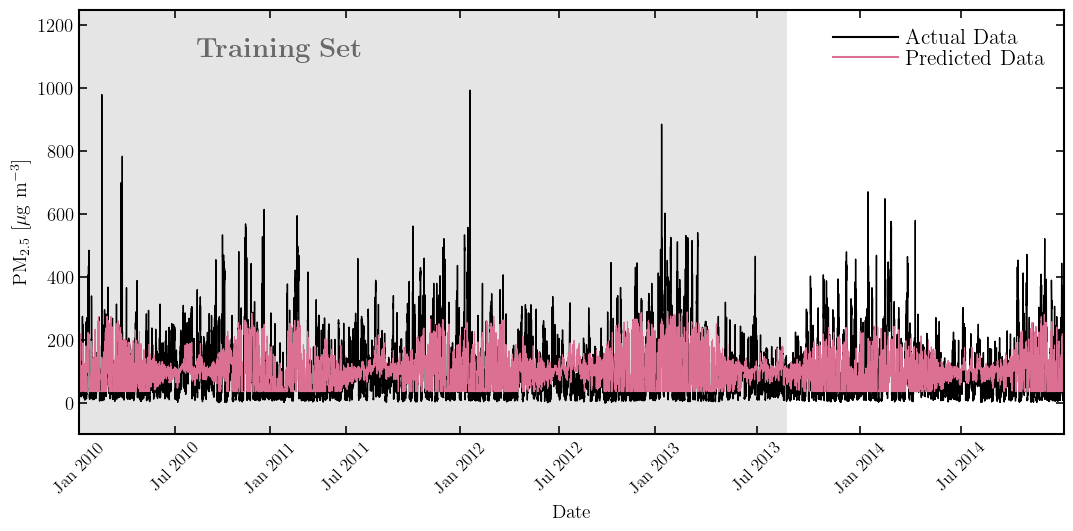

In [22]:
# Initialize figure
fig, ax = plt.subplots(figsize=(15.25/1.2, 6.75/1.2), nrows=1, ncols=1, dpi=100)
ax.xaxis.set_tick_params(direction='in', which='both'); ax.yaxis.set_tick_params(direction='in', which='both')
ax.xaxis.set_ticks_position('both'); ax.yaxis.set_ticks_position('both')
ax.set_xscale('linear'); ax.set_yscale('linear');
ax.set_xlabel(r'$\rm Date$'); ax.set_ylabel(r'$\rm PM_{2.5}\ [\mu g\ m^{-3}]$')
ax.set_ylim(-100, 1250)

# Plot results
ax.plot(dataY_plot, color='k', lw=1.0) 
ax.plot(data_predict, color='palevioletred', lw=0.75)

# Depict size of the training set
ax.fill_betweenx(np.linspace(-100, 1250), TRAIN_LIMIT, 0, edgecolor="None", facecolor='k', alpha=0.10)
ax.text(5000, 1100, r"\boldmath$\rm Training\ Set$", fontsize=20, color='dimgray', zorder=1)

# Generate modified x-labels based on index location
ax.set_xlim(0.0, df.shape[0]);
ax.xaxis.set_ticks(np.linspace(0.0, df.shape[0], 5))
date_list = ["2010-01-02", "2010-07-01", "2011-01-02", "2011-06-01", 
             "2012-01-02", "2012-07-01", "2013-01-02", "2013-07-01", 
             "2014-01-02", "2014-07-01"]
ind_list = []
for date in date_list:
    ind_list.append(df.index.get_loc(date).start)
labels = [r"$\rm Jan\ 2010$", r"$\rm Jul\ 2010$", r"$\rm Jan\ 2011$", r"$\rm Jul\ 2011$", 
          r"$\rm Jan\ 2012$", r"$\rm Jul\ 2012$", r"$\rm Jan\ 2013$", r"$\rm Jul\ 2013$", 
          r"$\rm Jan\ 2014$", r"$\rm Jul\ 2014$"]
ax.set_xticks(ind_list)
ax.set_xticklabels(labels, rotation=45, fontsize=12.5)

# Plot line legend
ax.plot(0,0, color='k', lw=1.5, label=r'$\rm Actual\ Data$')
ax.plot(0,0, color='palevioletred', lw=1.5, label=r'$\rm Predicted\ Data$')
ax.legend(frameon=False, loc='upper right', fontsize=15.5, handlelength=3, handletextpad=0.3, labelspacing=0.05)

fig.savefig('figures/predicted-pollution.jpg', bbox_inches='tight', dpi=200);

plt.show()

The gray band encapsulates the amount of the black curve used for the training set, which looks to be around 60-75%. 

Now lets recreate the previous figure for readings from 1 May to 31 December 2014:

In [23]:
# Define preprocessing functions (so we can apply the inverse transformation)
ss = StandardScaler()
mm = MinMaxScaler()

# Mask the dates and reset database index
START_DATE = "2014-05-01"; END_DATE = "2014-12-31"
mask = (df.index >= START_DATE) & (df.index <= END_DATE)
dfm = df.loc[mask, :] 

# Old transformers
df_X_ss = ss.fit_transform(dfm.iloc[:, 6:-1].drop('cbwd', axis=1)) 
df_y_mm = mm.fit_transform(dfm.iloc[:, 5:6])

# Converting to Tensors
df_X_ss = Variable(torch.Tensor(df_X_ss)) 
df_y_mm = Variable(torch.Tensor(df_y_mm))

# Reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))

# Pass through forward method and convert to numpy
train_predict = lstm(df_X_ss)
data_predict = train_predict.data.numpy() 
dataY_plot = df_y_mm.data.numpy()

# Inverse transformation scalings to return original values
data_predict = mm.inverse_transform(data_predict) 
dataY_plot = mm.inverse_transform(dataY_plot)

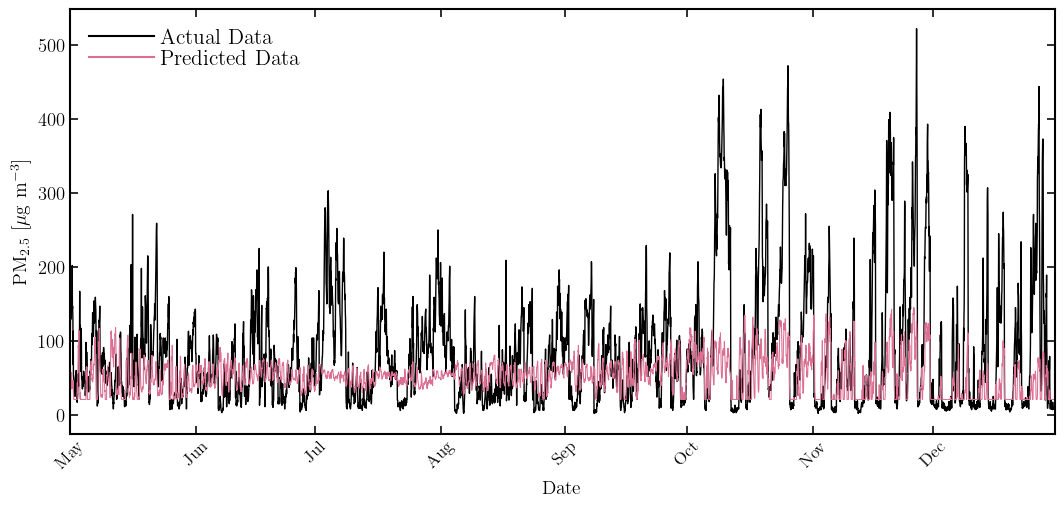

In [24]:
# Plotting setup
fig, ax = plt.subplots(figsize=(15.25/1.2, 6.75/1.2), nrows=1, ncols=1, dpi=100)
ax.xaxis.set_tick_params(direction='in', which='both'); ax.yaxis.set_tick_params(direction='in', which='both')
ax.xaxis.set_ticks_position('both'); ax.yaxis.set_ticks_position('both')
ax.set_xscale('linear'); ax.set_yscale('linear');
ax.set_xlabel(r'$\rm Date$'); ax.set_ylabel(r'$\rm PM_{2.5}\ [\mu g\ m^{-3}]$')

# Plot results
ax.plot(dataY_plot, color='k', lw=1.0) 
ax.plot(data_predict, color='palevioletred', lw=0.75)

# Fenerate modified x-labels based on index location
ax.set_xlim(0.0, dfm.shape[0]);
ax.xaxis.set_ticks(np.linspace(0.0, dfm.shape[0], 8))
date_list = ["2014-05-01", "2014-06-01", "2014-07-01", "2014-08-01", 
             "2014-09-01", "2014-10-01", "2014-11-01", "2014-12-01"]
ind_list = []
for date in date_list:
    ind_list.append(dfm.index.get_loc(date).start)
labels = [r"$\rm May$", r"$\rm Jun$", r"$\rm Jul$", r"$\rm Aug$", 
          r"$\rm Sep$", r"$\rm Oct$", r"$\rm Nov$", r"$\rm Dec$"]
ax.set_xticks(ind_list)
ax.set_xticklabels(labels, rotation=45, fontsize=12.5)

# Plot line legend
ax.plot(0,0, color='k', lw=1.5, label=r'$\rm Actual\ Data$')
ax.plot(0,0, color='palevioletred', lw=1.5, label=r'$\rm Predicted\ Data$')
ax.legend(frameon=False, loc='upper left', fontsize=15.5, handlelength=3, handletextpad=0.3, labelspacing=0.05)

plt.show()